# Project overview
Project Overview

Named Entity Recognition models are typically trained on a specific dataset with its own label definitions, tokenization patterns, and annotation rules. When such a model is applied to a different dataset, a common but often overlooked issue appears: the label spaces do not match.
This project investigates these underlying issues:
* How mismatched label spaces distort predictions, especially when the model assigns labels that the dataset does not define.
* How subword tokenization complicates alignment, because entity tags must be mapped from words to subtokens in a consistent and loss-aware way.
* Why naïvely fine-tuning a pretrained NER model may fail, if parts of its classifier head receive no supervision.

The goal is to examine these challenges directly, understand how they manifest in predictions, and show why resolving label-space alignment is essential before any meaningful fine-tuning can occur.

In [51]:
# !pip install transformers[torch] datasets evaluate seqeval torch matplotlib seaborn


In [52]:
import random
from collections import Counter
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
from torch.utils.data import DataLoader

from datasets import load_dataset
import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
    default_data_collator,
)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

# Named Entity Recognition (NER) with Cross-Dataset Label Mapping


#### WikiANN Dataset
The WikiANN dataset contains Wikipedia sentences annotated for NER containing word tokens, ner_tags, languages and readable spans. Lets look inside 

In [53]:
wikiann = load_dataset("wikiann", "en")

print(wikiann)

for split in wikiann.keys():
    print(f"\nSplit: {split}")
    print(wikiann[split])
    print("Example sample:", wikiann[split][0])


DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 20000
    })
})

Split: validation
Dataset({
    features: ['tokens', 'ner_tags', 'langs', 'spans'],
    num_rows: 10000
})
Example sample: {'tokens': ['Sioux', 'Falls', 'Arena', '(', 'Sioux', 'Falls', ',', 'South', 'Dakota', ')'], 'ner_tags': [3, 4, 4, 0, 5, 6, 6, 6, 6, 0], 'langs': ['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en'], 'spans': ['ORG: Sioux Falls Arena', 'LOC: Sioux Falls , South Dakota']}

Split: test
Dataset({
    features: ['tokens', 'ner_tags', 'langs', 'spans'],
    num_rows: 10000
})
Example sample: {'tokens': ['Shortly', 'afterward', ',', 'an', 'encouraging', 'response', 'influenced', 'him', 'to', 'go', 'to', 'India', 

Understanding 1st example:

The sentence in validation is split into tokens:
["Sioux", "Falls", "Arena", "(", "Sioux", "Falls", ",", "South", "Dakota", ")"]

ner_tags correspond to each token using integer IDs:
* 0 → O (not an entity)
* 3 → B-ORG
* 4 → I-ORG
* 5 → B-LOC
* 6 → I-LOC

So:

* "Sioux" → tag 3 → B-ORG
* "Falls" → tag 4 → I-ORG
* "Arena" → tag 4 → I-ORG

=> the entity ORG: Sioux Falls Arena


Lets map dictionaries from the lable names and integers


In [54]:
wikiann_label_names = wikiann["train"].features["ner_tags"].feature.names
wikiann_id2label: Dict[int, str] = {i: name for i, name in enumerate(wikiann_label_names)}
wikiann_label2id: Dict[str, int] = {name: i for i, name in wikiann_id2label.items()}
wikiann_id2label, wikiann_label2id

({0: 'O',
  1: 'B-PER',
  2: 'I-PER',
  3: 'B-ORG',
  4: 'I-ORG',
  5: 'B-LOC',
  6: 'I-LOC'},
 {'O': 0,
  'B-PER': 1,
  'I-PER': 2,
  'B-ORG': 3,
  'I-ORG': 4,
  'B-LOC': 5,
  'I-LOC': 6})

### Label distibution

In [55]:
all_tags = []

for split in wikiann.keys():
    ds_split = wikiann[split]
    for example in ds_split:
        all_tags.extend(example["ner_tags"])

tag_names = [wikiann_id2label[tag_id] for tag_id in all_tags]
tag_counts = Counter(tag_names)

print("Label counts across all WikiANN splits:")
for label, count in tag_counts.most_common():
    print(f"{label:7}: {count}")

Label counts across all WikiANN splits:
O      : 163071
I-ORG  : 46471
I-PER  : 29698
I-LOC  : 25981
B-ORG  : 18844
B-LOC  : 18836
B-PER  : 18355


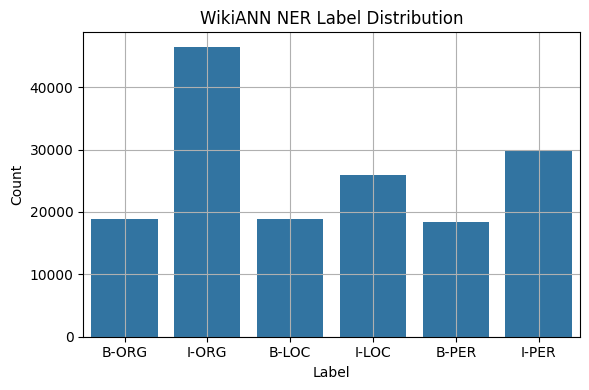

In [56]:
plt.figure(figsize=(6, 4))
sns.barplot(x=[k for k in tag_counts.keys() if k != 'O'], y=[v for k,v in tag_counts.items() if k != 'O'])
plt.title("WikiANN NER Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.grid()
plt.show()

Biggest amount of the NER tags belons to continuation of Organization Names, theyhave more ite,s compared to continuations od person and location names

## Tokenizer

In [57]:
model_name = "dslim/bert-base-NER"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [58]:
split = random.choice(list(wikiann.keys()))
ds_s = wikiann[split]
sample_idx = random.choice(range(len(ds_s)))
tokens = ds_s[sample_idx]["tokens"]

print(f"\nOriginal tokens ({split}, index {sample_idx}):")
print(tokens)

tokenized = tokenizer(tokens, is_split_into_words=True)
print("Tokenized input_ids:", tokenized["input_ids"])
print("Tokenized tokens:", tokenizer.convert_ids_to_tokens(tokenized["input_ids"]))



Original tokens (train, index 3648):
['The', 'Pavilion', '(', 'UC', 'Davis', ')']
Tokenized input_ids: [101, 1109, 16790, 113, 16991, 3635, 114, 102]
Tokenized tokens: ['[CLS]', 'The', 'Pavilion', '(', 'UC', 'Davis', ')', '[SEP]']


We can see WikiAnn original tokens first as Id's in Bert's vocabulary and then as "tokenized tokens" - with Bert tokenization.

Bert has:
* [CLS] - a special token at the beginning of every sequence
* [SEP] - a sequence boundary token marking the end of the sentence

but also Bert splits wrokwns differently, for example:
* "'", "''" turns into "'", "'", "'" cause Bert splits sign "'" from "' '" into 2 separate tokens
* and 'Roff' is split to 'R' and '##off' cause it knows this suffix "off" and sees it as continuation of previous word

These labels are not aligned properly to the tokenized input now.


According to HuggingFace Token Classification tutorial:
*“Only the first token of each word should receive a label.
All other subtokens must receive the label -100 so they are ignored during loss computation.”*

So let's create a function to align them

In [59]:
def align_labels_with_tokens(examples, word_list: bool = False):
    """
    Align word-level NER labels with subword tokens produced by the tokenizer.
    
    Strategy:
    - Assign the entity label only to the first subtoken of each word.
    - Assign -100 to:
        * All inner subtokens,
        * Special tokens ([CLS], [SEP], [PAD], etc.).
    - This ensures that the loss is computed only on first subtokens.
    """
    tokenized_inputs = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True,
        max_length=512,
        padding="max_length",
    )
    labels = []
    word_ids_list = []
    for i, word_labels in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        word_ids_list.append(word_ids)

        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(word_labels[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    if word_list:
        tokenized_inputs["word_ids"] = word_ids_list
    return tokenized_inputs


In [60]:
tokenized_wikiann = {}

for split in list(wikiann.keys()):
    print(f"Tokenizing and aligning labels for split: {split}")
    tokenized_wikiann[split] = wikiann[split].map(
        align_labels_with_tokens,
        batched=True,
        remove_columns=wikiann[split].column_names,
    )


Tokenizing and aligning labels for split: validation
Tokenizing and aligning labels for split: test
Tokenizing and aligning labels for split: train


Map: 100%|██████████████████████████████████████████████| 20000/20000 [00:04<00:00, 4401.88 examples/s]


### Pretrained NER model

In [61]:
model = AutoModelForTokenClassification.from_pretrained(model_name)
model.to(device)

print(model)
print("\nNumber of labels in model:", model.num_labels)
print("Model id2label:", model.config.id2label)
print("Model label2id:", model.config.label2id)

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

We see a new entity - MISC – miscellaneous, for entities that don’t fit into PER/ORG/LOC like nationalities, events, products, works of art, etc. But there is no MISC class in WikiANN.
But even though the pretrained model was trained on CoNLL-2003, it still recognizes PER / ORG / LOC correctly when you run it directly on WikiANN before fine-tuning. lets check it



In [62]:
def check_predictions(model, row: int, split: str = "test", print_res: bool = False, to_device: bool = False):
    input_ids = tokenized_wikiann[split][row]["input_ids"]
    attention_mask = tokenized_wikiann[split][row]["attention_mask"]

    input_ids_tensor = torch.tensor([input_ids])
    attention_mask_tensor = torch.tensor([attention_mask])

    if to_device:
        model_device = next(model.parameters()).device
        input_ids_tensor = input_ids_tensor.to(model_device)
        attention_mask_tensor = attention_mask_tensor.to(model_device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids_tensor, attention_mask=attention_mask_tensor)

    predictions = torch.argmax(outputs.logits, dim=-1)
    id2label = model.config.id2label
    predicted_labels = [id2label[idx.item()] for idx in predictions[0]]

    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    if print_res:
        print(f"\nExample row {row} from split '{split}':")
        for token, label in zip(tokens, predicted_labels):
            if "[PAD]" not in token:
                print(f"{token:15} -> {label}")

    return predicted_labels, tokens


In [63]:
random_row = random.choice(range(len(tokenized_wikiann["test"])))
row_labels, row_tokens = check_predictions(model, random_row, print_res=True, split="test", to_device=True)


Example row 409 from split 'test':
[CLS]           -> O
'               -> O
'               -> O
'               -> O
Shan            -> B-PER
##i             -> B-PER
Davis           -> I-PER
'               -> O
'               -> O
'               -> O
[SEP]           -> O


The model correctly identified "Charlie Smith" as a PERSON entity cause it knows what a person is, but it also added label B-MISC for word "Romani" 

### Initial finetuning 
we want to adapt the pretrained CoNLL NER model to the WikiANN dataset so it can recognize entities according to WikiANN’s style, vocabulary, and annotation rules. The MISC mismatch makes the fine-tuned model sometimes perform worse than the pretrained one.

In [64]:
training_args = TrainingArguments(
    output_dir="./ner-wikiann-bert",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3, 
    weight_decay=0.01,
    push_to_hub=False,
    logging_steps=50,
)

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
label_names = wikiann["train"].features["ner_tags"].feature.names

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_wikiann["train"],
    eval_dataset=tokenized_wikiann["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

/tmp/ipykernel_10024/2636110953.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [66]:
train_result = trainer.train()
print(train_result)


Epoch,Training Loss,Validation Loss
1,0.255100,0.242228
2,0.159800,0.272253
3,0.094500,0.318540


TrainOutput(global_step=7500, training_loss=0.16883512010574342, metrics={'train_runtime': 694.3901, 'train_samples_per_second': 86.407, 'train_steps_per_second': 10.801, 'total_flos': 1.57310602573824e+16, 'train_loss': 0.16883512010574342, 'epoch': 3.0})


In [67]:
fine_tuned_model = trainer.model.to(device)

Let's compare before and after finetuning

In [86]:
def compare_before_and_after(model_1, model_2, num_examples_to_check = 100):
    random_rows = [random.choice(range(len(tokenized_wikiann["test"]))) for _ in range(num_examples_to_check)]
    before_tokens = []
    before_labels = []
    after_tokens = []
    after_labels = []
    
    for idx, row in enumerate(random_rows):
        old_labels, old_tokens = check_predictions(
            model_1,
            row,
            split="test",
            to_device=True
        )
    
        new_labels, new_tokens = check_predictions(
            model_2,
            row,
            split="test",
            to_device=True
        )
    
        before_tokens.append(old_tokens)
        before_labels.append(old_labels)
    
        after_tokens.append(new_tokens)
        after_labels.append(new_labels)
        
    for i, row in enumerate(random_rows):
        old_toks = before_tokens[i]
        new_toks = after_tokens[i]
        old_labs = before_labels[i]
        new_labs = after_labels[i]
    
        changes = []
    
        for tok, old_lab, new_lab in zip(old_toks, old_labs, new_labs):
            if tok.startswith("[PAD]"):
                continue
            if old_lab != new_lab:
                changes.append((tok, old_lab, new_lab))
    
        if changes:
            print(f"\nChanges for example row {row}:")
            print(f"{'Token':15} {'OLD label':12} {'NEW label'}")
            for tok, old_lab, new_lab in changes:
                print(f"{tok:15} {old_lab:12} {new_lab}")
    return changes






In [70]:
changes = compare_before_and_after(model, fine_tuned_model)

In [71]:
changes

[]

#### Conclusion

Even though the model was fine-tuned on WikiANN, its predictions did not change compared to the pretrained model. This happens because the pretrained model was trained on CoNLL-2003 and expects four entity types (PER, ORG, LOC, MISC), while WikiANN provides only three and never contains MISC. As a result, the classifier head keeps its original MISC logits, receives no supervision for this label, and cannot fully adjust to the WikiANN label space. Therefore, fine-tuning updates the weights slightly but does not meaningfully alter the model’s predictions.

It means that we gotta change our approach. Let's reinitialize classifier with base Bert and make labels match Wikipedia Dataset


### Adapting finetuning

In [72]:
label_list = wikiann["train"].features["ner_tags"].feature.names

In [73]:
base_bert = "bert-base-cased"
base_model = AutoModelForTokenClassification.from_pretrained(
    base_bert,
    num_labels=len(label_list)
) 

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:
base_model.config.id2label = {i: label for i, label in enumerate(label_list)}
base_model.config.label2id = {label: i for i, label in enumerate(label_list)}


In [75]:
training_args = TrainingArguments(
    output_dir="./ner-wikiann-basebert",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=5, 
    weight_decay=0.01,
    push_to_hub=False,
    logging_steps=50,
)

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
label_names = wikiann["train"].features["ner_tags"].feature.names

trainer = Trainer(
    model=base_model,
    args=training_args,
    train_dataset=tokenized_wikiann["train"],
    eval_dataset=tokenized_wikiann["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

/tmp/ipykernel_10024/2076024500.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [76]:
train_result = trainer.train()
print(train_result)

Epoch,Training Loss,Validation Loss
1,0.257200,0.248796
2,0.190200,0.268698
3,0.146300,0.305117
4,0.052000,0.357116
5,0.062700,0.393440


TrainOutput(global_step=12500, training_loss=0.15951588114261628, metrics={'train_runtime': 1141.3463, 'train_samples_per_second': 87.616, 'train_steps_per_second': 10.952, 'total_flos': 2.61308568576e+16, 'train_loss': 0.15951588114261628, 'epoch': 5.0})


In [77]:
fine_tuned_base_model = trainer.model.to(device)

In [87]:
changes = compare_before_and_after(fine_tuned_model,fine_tuned_base_model)


Changes for example row 1679:
Token           OLD label    NEW label
R               B-MISC       B-PER
##ón            B-MISC       B-PER
##ald           B-MISC       B-PER
González        I-MISC       I-PER
B               I-MISC       I-PER
##rene          I-MISC       I-PER
##s             I-MISC       I-PER
Costa           B-ORG        B-LOC
Rica            I-ORG        I-LOC

Changes for example row 8935:
Token           OLD label    NEW label
Cook            B-PER        B-ORG
P               I-MISC       I-ORG
##VI            I-PER        I-ORG
R               O            B-ORG
+               O            I-ORG

Changes for example row 1424:
Token           OLD label    NEW label
Franz           B-ORG        B-LOC
Josef           I-ORG        I-LOC
Land            I-ORG        I-LOC
[SEP]           I-ORG        B-LOC

Changes for example row 9674:
Token           OLD label    NEW label
[CLS]           O            I-LOC
Z               B-ORG        B-LOC
##am            I-OR

After fixing the comparison function, the properly fine-tuned bert-base-cased model shows clear  improvements over the mismatched DSLIM model. The fine-tuned model correctly converts many wrong MISC → PER, ORG → LOC, and PER → ORG predictions, showing that it has truly learned WikiANN’s label conventions.
Now let's evaluate

### Evaluation

In [79]:
seqeval = evaluate.load("seqeval")


In [80]:
def evaluate_model_on_wikiann(
    model,
    tokenized_dataset,
    label_list,
    tokenizer,
    collapse_misc=False,
    batch_size=16,
    output_dir="./tmp-eval"
):
    eval_args = TrainingArguments(
        output_dir=output_dir,
        per_device_eval_batch_size=batch_size,
        do_train=False,
        do_eval=True,
        logging_strategy="no",
        save_strategy="no",
    )

    eval_trainer = Trainer(
        model=model,
        args=eval_args,
        data_collator=default_data_collator,
        tokenizer=tokenizer,
    )

    predictions = eval_trainer.predict(tokenized_dataset)

    logits = predictions.predictions
    true_label_ids = predictions.label_ids
    pred_label_ids = np.argmax(logits, axis=-1)

    all_true_labels = []
    all_pred_labels = []

    id2label = model.config.id2label

    for true_seq, pred_seq in zip(true_label_ids, pred_label_ids):
        ex_true = []
        ex_pred = []

        for t_id, p_id in zip(true_seq, pred_seq):
            if t_id == -100:
                continue

            true_label = label_list[t_id]
            pred_label = id2label[p_id]

            if collapse_misc and "MISC" in pred_label:
                pred_label = "O"

            ex_true.append(true_label)
            ex_pred.append(pred_label)

        if ex_true:
            all_true_labels.append(ex_true)
            all_pred_labels.append(ex_pred)

    metrics = seqeval.compute(
        predictions=all_pred_labels,
        references=all_true_labels
    )
    return metrics

In [83]:
metrics_dslim_orig = evaluate_model_on_wikiann(
    model=model,
    tokenized_dataset=tokenized_wikiann["test"],
    label_list=label_list,
    tokenizer=tokenizer,
    collapse_misc=True,
    output_dir="./eval-dslim-orig"
)

print("Original dslim/bert-base-NER on WikiANN (MISC -> O):")
for k in ["overall_precision", "overall_recall", "overall_f1", "overall_accuracy"]:
    print(f"{k}: {metrics_dslim_orig[k]}")

/tmp/ipykernel_10024/156498845.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


/opt/jupyter-server/.venv/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Original dslim/bert-base-NER on WikiANN (MISC -> O):
overall_precision: 0.0500208420175073
overall_recall: 0.03438888092849979
overall_f1: 0.04075740850810903
overall_accuracy: 0.5208027288798147


In [84]:
metrics_dslim_ft = evaluate_model_on_wikiann(
    model=fine_tuned_model,
    tokenized_dataset=tokenized_wikiann["test"],
    label_list=label_list,
    tokenizer=tokenizer,
    collapse_misc=True,
    output_dir="./eval-dslim-ft-3ep"
)

print("\ndslim fine-tuned 3 epochs on WikiANN (MISC -> O):")
for k in ["overall_precision", "overall_recall", "overall_f1", "overall_accuracy"]:
    print(f"{k}: {metrics_dslim_ft[k]}")


/tmp/ipykernel_10024/156498845.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


/opt/jupyter-server/.venv/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



dslim fine-tuned 3 epochs on WikiANN (MISC -> O):
overall_precision: 0.0500208420175073
overall_recall: 0.03438888092849979
overall_f1: 0.04075740850810903
overall_accuracy: 0.5208027288798147


In [85]:
metrics_base_ft = evaluate_model_on_wikiann(
    model=fine_tuned_base_model,
    tokenized_dataset=tokenized_wikiann["test"],
    label_list=label_list,
    tokenizer=tokenizer,
    collapse_misc=False,
    output_dir="./eval-base-ft"
)

print("\nProperly fine-tuned bert-base-cased on WikiANN:")
for k in ["overall_precision", "overall_recall", "overall_f1", "overall_accuracy"]:
#    print(f"{k}: {metrics_base_ft[k]}")

/tmp/ipykernel_10024/156498845.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(



Properly fine-tuned bert-base-cased on WikiANN:
overall_precision: 0.8336023580602148
overall_recall: 0.850981515976501
overall_f1: 0.8422022902116495
overall_accuracy: 0.9342429599382516


### Conclusion
The experiments clearly demonstrates the impact of correct label-space alignment in NER fine-tuning.
The pretrained dslim/bert-base-NER model performed very poorly on WikiANN (F1 ≈ 0.04) because its classifier head expects four CoNLL entity types, including MISC, which WikiANN does not use. When this mismatched model was fine-tuned for 3 epochs on WikiANN, the performance remained identical—showing that the head could not learn meaningful updates because one of its label dimensions received no supervision and the remaining ones were misaligned with the dataset.


But when BERT base model was initialized with a properly defined 7-label WikiANN classification head, the model converged successfully. After 5 epochs of fine-tuning, the new model achieved strong performance:
* Precision: 0.83
* Recall: 0.85
* F1: 0.84
* Accuracy: 0.93
 
it means that fine-tuning cannot succeed when the model’s label space does not match the dataset. Once the label mismatch was removed, BERT learned WikiANN effectively and achieved high-quality NER performance.